In [3]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

# Downloading trained weights from the inception model.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Instantiation model with pre-trained weights.
# 'include_top' = whether or not to include the fully connected layer at the end
# of the network (it's gonna be False because will be creating our own Dense 
# layer later and training it).
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Locking layers so that they are not retrained again when we use the 'fit' 
# function below.
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# Printing the summary of the model.
pre_trained_model.summary()
  
# Choosing a layer to be our last layer.
last_layer = pre_trained_model.get_layer("mixed7")
print("Last layer output shape: ", last_layer.output_shape)
last_output = last_layer.output

--2019-05-02 18:48:27--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   113MB/s    in 0.7s    

2019-05-02 18:48:28 (113 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
________

In [0]:
# Flattening the output layer to 1 dimension.
x = layers.Flatten()(last_output)

# Adding a fully connected layer with 1,024 hidden units and ReLU activation.
x = layers.Dense(1024, activation="relu")(x)

# Adding a dropout rate of 20%.
x = layers.Dropout(0.2)(x)    

# Adding a final sigmoid layer for classification
x = layers.Dense(1, activation="sigmoid")(x)           

# Creating model.
model = Model(pre_trained_model.input, x) 

# Compiling model.
model.compile(optimizer = "adam", 
              loss = "binary_crossentropy", 
              metrics = ['acc'])


In [12]:
# Downloading cats and dogs dataset.
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

# Unzipping file.
zip_file = zipfile.ZipFile("/tmp/cats_and_dogs_filtered.zip", 'r')
zip_file.extractall("/tmp")
zip_file.close()

# Creating directories that I'll be using.
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Adding our data-augmentation parameters to ImageDataGenerator.
training_data_generator = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
validation_data_generator = ImageDataGenerator(rescale = 1.0/255.0)

# Flowing training images in batches of 20 using training_data_generator generator.
training_data_generator = training_data_generator.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = "binary", 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using validation_data_generator generator
validation_data_generator =  validation_data_generator.flow_from_directory(validation_dir,
                                                          batch_size = 20,
                                                          class_mode = "binary", 
                                                          target_size = (150, 150))

--2019-05-02 20:05:31--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   222MB/s    in 0.3s    

2019-05-02 20:05:31 (222 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
history = model.fit_generator(
            training_data_generator,
            validation_data = validation_data_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2)

Epoch 1/100
50/50 [==============================] - 5s 91ms/step - loss: 0.5924 - acc: 0.9290
 - 22s - loss: 0.1284 - acc: 0.9465 - val_loss: 0.5924 - val_acc: 0.9290
Epoch 2/100
50/50 [==============================] - 5s 92ms/step - loss: 0.3684 - acc: 0.9600
 - 19s - loss: 0.1101 - acc: 0.9545 - val_loss: 0.3684 - val_acc: 0.9600
Epoch 3/100
50/50 [==============================] - 5s 92ms/step - loss: 0.4492 - acc: 0.9420
 - 19s - loss: 0.1392 - acc: 0.9460 - val_loss: 0.4492 - val_acc: 0.9420
Epoch 4/100
50/50 [==============================] - 5s 92ms/step - loss: 0.3588 - acc: 0.9500
 - 19s - loss: 0.1212 - acc: 0.9545 - val_loss: 0.3588 - val_acc: 0.9500
Epoch 5/100
50/50 [==============================] - 5s 92ms/step - loss: 0.4037 - acc: 0.9470
 - 20s - loss: 0.1175 - acc: 0.9525 - val_loss: 0.4037 - val_acc: 0.9470
Epoch 6/100
50/50 [==============================] - 5s 108ms/step - loss: 0.4623 - acc: 0.9400
 - 20s - loss: 0.1095 - acc: 0.9575 - val_loss: 0.4623 - val_acc

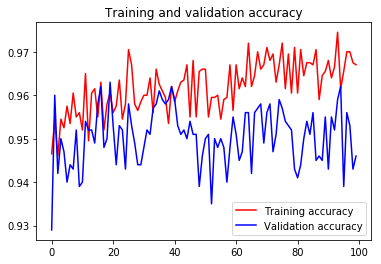

In [14]:
# Getting basic model information to plot.
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plotting accuracy and loss values for both traingin and validation sets.
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

# I still got a pretty bad validation for my validation set.